In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import norm

from scipy import stats


In [2]:
#data_path = Path('data')/'customer_dim.csv'
customer_df = pd.read_csv('data/customer_dim.csv', encoding='ISO-8859-1')
fact_df = pd.read_csv('data/fact_table.csv', encoding='ISO-8859-1') #time_key
time_df = pd.read_csv('data/time_dim.csv', encoding='ISO-8859-1') #time_key
transaction_df = pd.read_csv('data/Trans_dim.csv', encoding='ISO-8859-1') #time_key
item_df = pd.read_csv('data/item_dim.csv', encoding='ISO-8859-1')
store_df = pd.read_csv('data/store_dim.csv', encoding='ISO-8859-1')

store_df.query('upazila == "KOTWALI"')

,store_key,division,district,upazila
257,S00258,DHAKA,DHAKA,KOTWALI
439,S00440,CHITTAGONG,CHITTAGONG,KOTWALI
635,S00636,DHAKA,DHAKA,KOTWALI
636,S00637,DHAKA,DHAKA,KOTWALI
703,S00704,CHITTAGONG,CHITTAGONG,KOTWALI


GOAL: Find when people come back the most to a store_key and find which item sells the most during that time period and do a loyalty program where if they come back to the store they can get a discount on that item

In [3]:
fact_df = pd.merge(fact_df, transaction_df, how='left', on='payment_key')
fact_df = pd.merge(fact_df, customer_df, how = 'left', on = 'coustomer_key')
fact_df = pd.merge(fact_df, time_df, how='left', on='time_key')
fact_df = pd.merge(fact_df, item_df, how='left', on='item_key')
fact_df = pd.merge(fact_df, store_df, how = 'left', on = 'store_key')
fact_df.head()

,payment_key,coustomer_key,time_key,item_key,store_key,quantity,unit_x,unit_price_x,total_price,trans_type,...,year,item_name,desc,unit_price_y,man_country,supplier,unit_y,division,district,upazila
0,P026,C004510,T049189,I00177,S00307,1,ct,35.0,35.0,card,...,2016,M&M Peanut Candy 1.7 oz,Food - Chocolate,35.0,Netherlands,Bolsius Boxmeer,ct,DHAKA,JAMALPUR,ISLAMPUR
1,P022,C008967,T041209,I00248,S00595,1,rolls,26.0,26.0,card,...,2018,Charmin Ultra Bath Tissue,Kitchen Supplies,26.0,Bangladesh,DENIMACH LTD,rolls,DHAKA,DHAKA,CANTONMENT
2,P030,C007261,T03633,I00195,S00496,8,ct,12.5,100.0,card,...,2016,Dole Fruit in Gel Cups 4.3 oz,Food - Healthy,12.5,poland,CHROMADURLIN S.A.S,ct,CHITTAGONG,NOAKHALI,BEGUMGANJ
3,P032,C007048,T084631,I00131,S0086,8,ct,14.0,112.0,card,...,2020,Paper Bowls 20 oz Ultra Strong,Dishware - Bowls,14.0,Bangladesh,DENIMACH LTD,ct,RANGPUR,RANGPUR,KAUNIA
4,P014,C006430,T071276,I00050,S00488,8,cans,8.0,64.0,card,...,2014,Waterloo Sparkling Watermelon 12oz,a. Beverage Sparkling Water,8.0,poland,CHROMADURLIN S.A.S,cans,CHITTAGONG,KHAGRACHHARI,MATIRANGA


In [4]:
fact_df = fact_df.rename(columns ={'unit_x':'unit','unit_price_x':'unit_price'})
df = fact_df.drop(columns=['payment_key','time_key','item_key','unit_price_y','unit_y'])

Text(0.5, 1.0, 'Each Year Total Price')

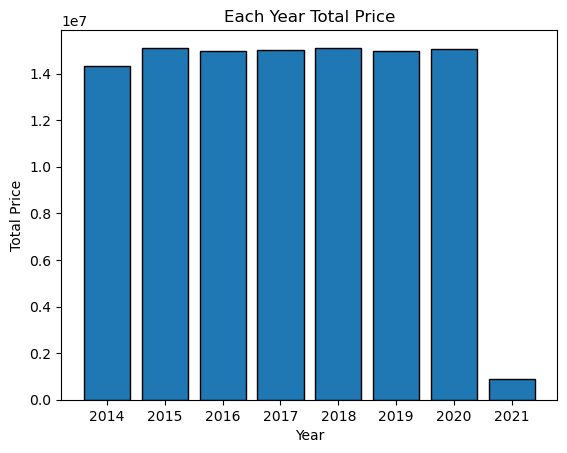

In [5]:
annual_price = df.groupby('year')[['total_price']].sum().reset_index()
plt.bar(annual_price['year'], annual_price['total_price'], edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Total Price')
plt.title('Each Year Total Price')

Text(0, 0.5, 'Quantaty')

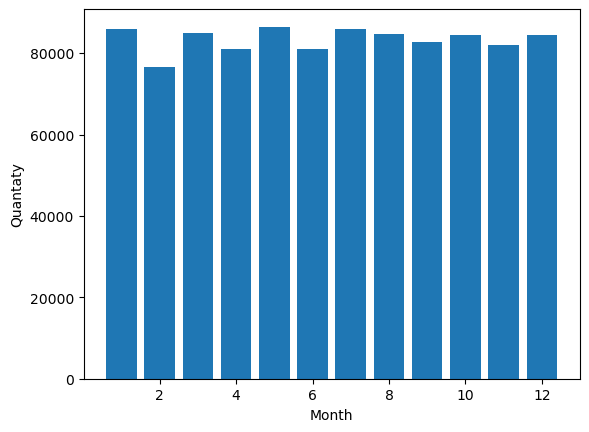

In [6]:
quantaty_total_month = df.groupby('month')[['quantity']].count().reset_index()

plt.bar(quantaty_total_month['month'],quantaty_total_month['quantity'])
plt.xlabel('Month')
plt.ylabel('Quantaty')

In [7]:
a = df.groupby(["month","year"])["quantity"].sum().to_frame()
a

quantity
month year          
1     2014     28280
      2015     70575
      2016     68836
      2017     73889
      2018     73564
...              ...
12    2016     69928
      2017     68936
      2018     75316
      2019     69469
      2020     76596

[85 rows x 1 columns]

In [8]:
df['item_combined'] = df['quantity'].astype(str)+' ' + df['item_name']

combined.groupby('upazila').agg({'total_price':'sum','quantity':'sum', 'date': lambda x: list(x),'bank_name': lambda x: list(x),'trans_type': lambda x: list(x),'item_combined':lambda x: list(x),'division':'max','district':'max'})

Get all the recurring customers upazila 

In [9]:
df['date'] = pd.to_datetime(df['date'], dayfirst = True)

In [10]:
grouped = df[['store_key','coustomer_key','date','total_price','quantity','item_combined','upazila','district','division']]
grouped = grouped.groupby(['store_key','coustomer_key']).agg({'total_price':'sum','quantity':'sum','date': lambda x: list(x),'item_combined':lambda x: list(x)})
grouped['times_visited'] = grouped['date'].transform(len)
grouped = grouped[grouped['times_visited']> 1]

In [11]:
grouped

total_price  quantity  \
store_key coustomer_key                          
S0001     C000154              75.75        10   
          C000209             252.00        12   
          C000293             241.50        15   
          C000638             272.00        18   
          C000822             290.00        10   
...                              ...       ...   
S0099     C008798             261.00        17   
          C008820             222.00        14   
          C008829             174.00        12   
          C008929             206.00        10   
          C008932             161.00        11   

                                                               date  \
store_key coustomer_key                                               
S0001     C000154        [2020-01-03 20:48:00, 2020-02-15 01:23:00]   
          C000209        [2021-01-13 20:15:00, 2014-10-07 23:40:00]   
          C000293        [2017-12-27 15:03:00, 2019-11-20 13:18:00]   
          C000638        [2019-07-04 23:45:00, 2018-12-17 20:22:00]   
          C000822        [2016-06-21 12:55:00, 2014-07-01 19:42:00]   
...                                                             ...   
S0099     C008798        [2015-11-21 07:45:00, 2018-11-24 07:18:00]   
          C008820        [2017-11-26 02:11:00, 2018-06-04 14:05:00]   
          C008829        [2018-02-19 10:38:00, 2019-08-11 07:51:00]   
          C008929        [2014-04-20 20:26:00, 2018-09-19 13:05:00]   
          C008932        [2015-03-21 11:43:00, 2020-12-27 10:16:00]   

                                                             item_combined  \
store_key coustomer_key                                                      
S0001     C000154        [1 Cascade Gel w/ Dawn Dishwasher, 9 Diet Coke...   
          C000209        [8 Brisk Lemon Iced Tea - 12 oz cans, 4 Foam C...   
          C000293        [4 Fresca Original - 12 oz cans, 11 Clorox Dis...   
          C000638        [8 Hershey Nuggets, 10 Go-Gurt Low Fat Yogurt,...   
          C000822        [3 Muscle Milk Protein Shake Strbry. 11oz, 7 F...   
...                                                                    ...   
S0099     C008798        [11 Equal Sweetener, 6 La Croix Sparkling Grap...   
          C008820        [8 Keebler Cookie & Cracker Variety, 6 Famous ...   
          C008829        [11 Austin Cookie Cracker Variety, 1 Sobe Zero...   
          C008929        [1 Waterloo Sparkling Lime 12oz, 9 Premier Pro...   
          C008932        [6 Dial Anti-bacterial  Foam 7.5oz, 5 Hershey ...   

                         times_visited  
store_key coustomer_key                 
S0001     C000154                    2  
          C000209                    2  
          C000293                    2  
          C000638                    2  
          C000822                    2  
...                                ...  
S0099     C008798                    2  
          C008820                    2  
          C008829                    2  
          C008929                    2  
          C008932                    2  

[67845 rows x 5 columns]

In [12]:
df['store_key'].value_counts().idxmax()

'S0039'

In [13]:
store = grouped.loc['S0039']
store

,total_price,quantity,date,item_combined,times_visited
coustomer_key,,,,,
C000245,179.5,17,"[2019-08-23 11:44:00, 2016-05-31 19:10:00]","[10 Diet Pepsi - 12 oz cans, 7 Dark Chocolate ...",2
C000302,288.0,18,"[2020-08-06 21:46:00, 2019-07-30 15:55:00]","[7 Fiber One 90 Calorie Fudge Brownies, 11 La ...",2
C000346,236.0,15,"[2018-10-22 10:26:00, 2019-03-01 01:01:00]","[11 Nabisco Cookie Variety Pk Oreo/ChocChip, 4...",2
C000363,426.0,19,"[2018-02-28 08:30:00, 2019-07-02 06:16:00]","[8 Honey Packets , 11 Coffee-Mate Original Fl...",2
C000386,52.0,5,"[2019-05-24 13:20:00, 2016-11-02 21:09:00]","[2 Austin Toasty Crackers w/ PBtr, 3 Waterloo ...",2
...,...,...,...,...,...
C008506,142.0,10,"[2020-06-21 04:59:00, 2016-08-01 15:32:00]","[6 Plastic Knives White Heavyweight, 4 Dawn U...",2
C008808,270.0,18,"[2019-04-14 10:55:00, 2014-07-27 04:53:00]","[10 Nabisco Classic Mix ccooki, cracker, 8 Fol...",2
C008884,478.0,18,"[2020-12-17 09:27:00, 2015-03-15 07:52:00]","[7 Monster Zero Ultra 16 oz, 11 Crunchy Granol...",2


In [14]:
store['times_visited'].value_counts()

2    93
3     5
4     1
Name: times_visited, dtype: int64

In [15]:
store.query('times_visited == 4').iloc[0][2]

[Timestamp('2017-05-01 21:11:00'),
 Timestamp('2018-11-28 11:27:00'),
 Timestamp('2017-05-22 17:52:00'),
 Timestamp('2017-01-13 17:47:00')]

In [16]:
temp = grouped.reset_index().query('coustomer_key == "C002958"').set_index('store_key')
temp = pd.merge(temp, store_df, how = 'left', left_index = True, right_on = 'store_key')
temp.set_index('store_key')

,coustomer_key,total_price,quantity,date,item_combined,times_visited,division,district,upazila
store_key,,,,,,,,,
S00104,C002958,383.00,19,"[2020-03-30 17:41:00, 2019-05-08 11:13:00]","[10 Detour Lower Sugar Protein Bar, 9 Sun Chip...",2,RAJSHAHI,BOGRA,SARIAKANDI
S00268,C002958,139.50,9,"[2020-01-26 23:11:00, 2018-08-03 09:34:00]","[7 Nat.Valley PeanutButter Protein Bars, 2 Bar...",2,DHAKA,DHAKA,RAMNA
S00321,C002958,295.00,20,"[2014-09-15 07:45:00, 2018-01-04 16:29:00]","[9 Lunchables Variety Pack Oscar Meyer, 11 Pur...",2,DHAKA,KISHOREGONJ,MITHAMAIN
S0039,C002958,267.00,19,"[2017-05-01 21:11:00, 2018-11-28 11:27:00, 201...","[4 Sugar in the Raw Packets, 1 Hershey Factory...",4,RANGPUR,DINAJPUR,BIRAMPUR
S00424,C002958,318.00,15,"[2016-07-11 05:17:00, 2017-09-05 20:57:00]","[6 Frito Classic Mix Variety, 9 Foam Coffee Cu...",2,CHITTAGONG,CHANDPUR,KACHUA
S00450,C002958,300.00,15,"[2015-08-01 13:53:00, 2020-06-11 13:17:00]","[6 Frito Classic Mix Variety, 9 Muscle Milk Pr...",2,CHITTAGONG,CHITTAGONG,SANDWIP
S00480,C002958,138.75,15,"[2019-01-08 06:56:00, 2019-01-04 01:45:00]","[9 Diet Gingerale 12 oz cans, 6 Kellogg's Cere...",2,CHITTAGONG,FENI,FULGAZI


## Hypothesis testing:


Null hypothesis: There is no difference in the average total cost at store "S0039" between quarter 2 and quarter 4.

Alternative hypothesis: There is a difference in the average total cost at store "S0039" between quarter 2 and quarter 4.

In [17]:
grouped_quarter_total_price = df.query('store_key=="S0039"').groupby('quarter')['total_price']
mean_quarters = grouped_quarter_total_price.mean()
mean_q2 = mean_quarters[1]
mean_q4 = mean_quarters[3]

std_quarters = grouped_quarter_total_price.std()
std_q2 = std_quarters[1]
std_q4 = std_quarters[3]

# count_quarters = grouped_quarter_total_price.count()
# n_q2 = count_quarters[1]
# n_q4 = count_quarters[3]


data_q2 = df[(df['store_key'] == 'S0039') & (df['quarter'] == 'Q2')]['total_price']
data_q4 = df[(df['store_key'] == 'S0039') & (df['quarter'] == 'Q4')]['total_price']

# heck for equal variances
levene_stat, levene_p = stats.levene(data_q2, data_q4)
levene_p

0.042310554176778495

In [18]:
# Perform the t-test
t_stat, p_value = stats.ttest_ind(data_q2, data_q4, equal_var=(levene_p > 0.05))
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: -2.39701153327224, P-value: 0.016789136736470405


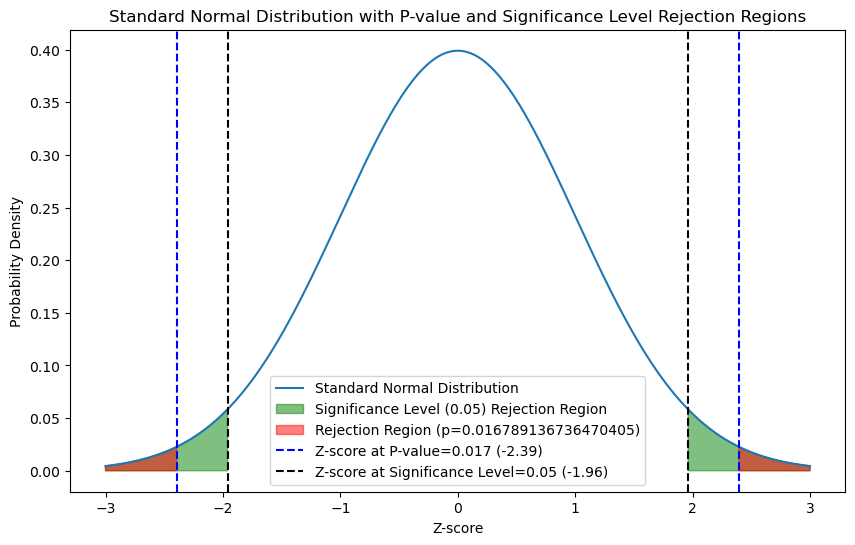

In [19]:
# Define the range for the x-axis
x = np.linspace(-3, 3, 1000)

# Calculate the standard normal distribution
y = norm.pdf(x)

# Calculate the z-score for significance level = 0.05 (two-tailed)
z_score_005 = norm.ppf(0.05/2)  # Two-tailed test

# Calculate the z-score for p-value = 0.017
z_score_017 = norm.ppf(p_value/2)  # Two-tailed test

# Plotting the curve
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Standard Normal Distribution')

# Shade the rejection regions for significance level 0.05
plt.fill_between(x, y, where=(x <= z_score_005) | (x >= -z_score_005), color='green', alpha=0.5, label='Significance Level (0.05) Rejection Region')

# Shade the rejection regions for p-value 0.017
plt.fill_between(x, y, where=(x <= z_score_017) | (x >= -z_score_017), color='red', alpha=0.5, label=f'Rejection Region (p={p_value})')

# Add lines for Z-scores
plt.axvline(z_score_017, color='blue', linestyle='dashed', label=f'Z-score at P-value=0.017 ({z_score_017:.2f})')
plt.axvline(-z_score_017, color='blue', linestyle='dashed')
plt.axvline(z_score_005, color='black', linestyle='dashed', label=f'Z-score at Significance Level=0.05 ({z_score_005:.2f})')
plt.axvline(-z_score_005, color='black', linestyle='dashed')

# Add labels and title
plt.xlabel('Z-score')
plt.ylabel('Probability Density')
plt.title('Standard Normal Distribution with P-value and Significance Level Rejection Regions')
plt.legend()

plt.show()

Reject the Null Hypothesis: Conclude that there is a significant difference in the average total costs between the two quarters, which might warrant further investigation into the causes or factors contributing to this difference.

Enhanced customer satisfaction by offering competitive prices and deals during high-demand periods.


## Model

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression


In [24]:
model_df = df.query('store_key=="S0039"').reset_index(drop=True)
model_df.dtypes

coustomer_key            object
store_key                object
quantity                  int64
unit                     object
unit_price              float64
total_price             float64
trans_type               object
bank_name                object
name                     object
contact_no                int64
nid                       int64
date             datetime64[ns]
hour                      int64
day                       int64
week                     object
month                     int64
quarter                  object
year                      int64
item_name                object
desc                     object
man_country              object
supplier                 object
division                 object
district                 object
upazila                  object
item_combined            object
dtype: object

In [43]:
model_df

,coustomer_key,store_key,quantity,unit,unit_price,total_price,trans_type,bank_name,name,contact_no,...,quarter,year,item_name,desc,man_country,supplier,division,district,upazila,item_combined
0,C000070,S0039,11,cans,15.50,170.5,card,Bank Asia Limited,sandeep kumar,8801857439507,...,Q1,2014,Brisk Lemon Iced Tea - 12 oz cans,Beverage - Iced Tea,United States,MAESA SAS,RANGPUR,DINAJPUR,BIRAMPUR,11 Brisk Lemon Iced Tea - 12 oz cans
1,C001708,S0039,5,ct.,14.00,70.0,card,BRAC Bank Limited,sanjana,8801793902810,...,Q4,2014,Chinet Comfort Hot Cups with Lids 16oz,Dishware - Cups Hot,United States,MAESA SAS,RANGPUR,DINAJPUR,BIRAMPUR,5 Chinet Comfort Hot Cups with Lids 16oz
2,C003806,S0039,9,pack,19.50,175.5,card,Dhaka Bank Limited,gurpreet kaur,8801595033672,...,Q2,2017,Clorox Disinfecting Wipes,Kitchen Supplies,United States,MAESA SAS,RANGPUR,DINAJPUR,BIRAMPUR,9 Clorox Disinfecting Wipes
3,C004509,S0039,2,tins,12.00,24.0,card,Dhaka Bank Limited,sapna,8801977831335,...,Q2,2017,Altoids Small Packs Variety,Gum - Mints,China,"CHERRY GROUP CO.,LTD",RANGPUR,DINAJPUR,BIRAMPUR,2 Altoids Small Packs Variety
4,C008506,S0039,6,ct,15.00,90.0,card,Eastern Bank Limited,monika,8801619354475,...,Q2,2020,Plastic Knives White Heavyweight,Dishware - Utensils,Germany,Friedola 1888 GmbH,RANGPUR,DINAJPUR,BIRAMPUR,6 Plastic Knives White Heavyweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,C002244,S0039,10,rolls,26.00,260.0,card,Jamuna Bank Limited,ramkali,8801514625415,...,Q2,2017,Bounty Paper Towels Select a Size,Kitchen Supplies,United States,MAESA SAS,RANGPUR,DINAJPUR,BIRAMPUR,10 Bounty Paper Towels Select a Size
1493,C003814,S0039,4,cans,6.75,27.0,mobile,Nagad,priti,8801632831421,...,Q1,2020,Diet Mountain Dew 12oz cans,a. Beverage - Soda,Finland,HARDFORD AB,RANGPUR,DINAJPUR,BIRAMPUR,4 Diet Mountain Dew 12oz cans
1494,C008322,S0039,11,cans,16.00,176.0,card,South Bangla Agriculture and Commerce Bank Lim...,priyanka,8801930612734,...,Q2,2020,La Croix Sparkling Orange 12 oz,a. Beverage Sparkling Water,China,"CHERRY GROUP CO.,LTD",RANGPUR,DINAJPUR,BIRAMPUR,11 La Croix Sparkling Orange 12 oz
1495,C005372,S0039,7,bottles,22.00,154.0,card,Dhaka Bank Limited,neesa,8801938317186,...,Q2,2014,Premier Protein Shake Choc. 11oz,Beverage - Energy/Protein,United States,MAESA SAS,RANGPUR,DINAJPUR,BIRAMPUR,7 Premier Protein Shake Choc. 11oz


In [75]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = model_df[['unit_price', 'quarter', 'hour']]
y = model_df['total_price']

# Updated transformer with Polynomial Features
one_hot_encoder = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(drop='first'), ['hour','quarter']),
        ("poly", PolynomialFeatures(degree=3, include_bias=False), ['hour'])
    ],
    remainder="passthrough"
)


# Pipeline with Linear Regression
pipeline = Pipeline([
    ('one_hot_encoder', one_hot_encoder),
    ('linear', LinearRegression())  # Using LinearRegression here
])


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred, squared=False)
r_squared = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", mse)
print("R^2:", r_squared)




Root Mean Squared Error (RMSE): 62.571965997133994
R^2: 0.3594088731120427


In [78]:

# Retrieve the coefficients and the intercept
linear_model = pipeline.named_steps['linear']
coefficients = linear_model.coef_
intercept = linear_model.intercept_

feature_names = pipeline.named_steps['one_hot_encoder'].get_feature_names_out()

formula = f"y = {intercept:.2f}"
for coef, name in zip(coefficients, feature_names):
    formula += f" + ({coef:.2f})*{name}"

print("Regression Formula:")
print(formula)

Regression Formula:
y = -10.89 + (7.08)*onehot__hour_1 + (19.86)*onehot__hour_2 + (7.16)*onehot__hour_3 + (-14.84)*onehot__hour_4 + (1.95)*onehot__hour_5 + (1.14)*onehot__hour_6 + (-11.86)*onehot__hour_7 + (15.45)*onehot__hour_8 + (-1.53)*onehot__hour_9 + (5.07)*onehot__hour_10 + (-6.42)*onehot__hour_11 + (-12.12)*onehot__hour_12 + (-4.80)*onehot__hour_13 + (11.13)*onehot__hour_14 + (-4.22)*onehot__hour_15 + (-13.46)*onehot__hour_16 + (9.51)*onehot__hour_17 + (13.88)*onehot__hour_18 + (2.94)*onehot__hour_19 + (0.78)*onehot__hour_20 + (-1.49)*onehot__hour_21 + (-9.71)*onehot__hour_22 + (2.82)*onehot__hour_23 + (-7.46)*onehot__quarter_Q2 + (-2.82)*onehot__quarter_Q3 + (1.83)*onehot__quarter_Q4 + (4.55)*poly__hour + (-0.36)*poly__hour^2 + (0.01)*poly__hour^3 + (5.80)*remainder__unit_price
